# Breakout training with CNN

## Import Libraries

In [1]:
%matplotlib inline
import os
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
# Tracking version for saving weights
version = "03"

In [3]:
# Crea l'ambiente con il gioco

#env = gym.make('Breakout-v0').unwrapped
env = gym.make('BreakoutDeterministic-v4').unwrapped
#env = gym.make('BreakoutNoFrameskip-v4').unwrapped

## Set Up Device

We import IPython's display module to aid us in plotting images to the screen later.

In [4]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

## Deep Q-Network

In [28]:
class DQN(nn.Module):
    """Initialize a deep Q-learning network
    
    Hints:
    -----
        Original paper for DQN
    https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf
    """
  
    def __init__(self, img_height, img_width, n_actions):
        super().__init__()

        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d
        def conv2d_size_out(size, kernel_size, stride=1, padding=0):
            return int(size + 2 * padding - kernel_size) // stride  + 1
        
        convw = conv2d_size_out(
                    conv2d_size_out(
                        conv2d_size_out(img_height, kernel_size=8, stride=4
                    ), kernel_size=4, stride=2
                ), kernel_size=3, stride=1)
        convh = conv2d_size_out(
                    conv2d_size_out(
                        conv2d_size_out(img_width, kernel_size=8, stride=4
                    ), kernel_size=4, stride=2
                ), kernel_size=3, stride=1)
        
        linear_input_size = convw * convh * 64  # = 7 * 7 * 64 = 3136
        
        self.fc1 = nn.Linear(linear_input_size, 512)
        self.fc2 = nn.Linear(512, n_actions)


    def forward(self, x):
        """
        Calculates probability of each action.
        Called with either one element to determine next action, or a batch during optimization.
        NOTE: a single discrete state is collection of 4 frames
        :param x: processed state of shape b x 4 x 84 x 84
        :returns tensor of shape [batch_size, n_actions] (estimated action values)
        """
        x = x.to(device)
        x = F.relu(self.conv1(x))  # b x 32 x 20 x 20
        x = F.relu(self.conv2(x))  # b x 64 x 9 x 9
        x = F.relu(self.conv3(x))  # b x 64 x 7 x 7
        x = x.view(x.size(0), -1)  # b x (7 * 7 * 64)
        x = F.relu(self.fc1(x))    # b x 512
        x = self.fc2(x)            # b x  4
        return x

In [29]:
folder_save = "models"
os.makedirs(folder_save, exist_ok=True)

def exchange_weights(net1, net2):
    net1.load_state_dict(net2.state_dict())

def load_weights(net, filename):
    filename = os.path.join(folder_save, filename)
    net.load_state_dict(torch.load(filename))

def save_weights(net, filename: str):
    filename = os.path.join(folder_save, filename + ".pt")
    torch.save(net.state_dict(), filename)
    
def save_checkpoint(n, net, optimizer, num_episodes):
    checkpoint_dict = {
        "parameters": net.state_dict(),
        "optimizer": optimizer.state_dict(),
        "episode": num_episodes
    }
    folder_checkp = "models"
    os.makedirs(folder_checkp, exist_ok=True)
    filename = os.path.join(folder_save, folder_checkp, "checkpoint_" + n +".pt")
    torch.save(checkpoint_dict, filename)

## Experience class

In [30]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

In [31]:
e = Experience(2,3,1,4)
e

Experience(state=2, action=3, next_state=1, reward=4)

## Replay Memory

In [32]:
class ReplayMemory():
  
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0       # Number of experiences added to the memory

    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience  # overwrite the first experiences first
        self.push_count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size    # can we sample from memory?

    def __len__(self):
        return len(self.memory)

## Epsilon Greedy Strategy

In [33]:
class EpsilonGreedyStrategy():

    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, agent_current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * agent_current_step * self.decay)

## Reinforcement Learning Agent

In [35]:
class Agent():

    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions # number of actions that can be taken from a given state
        self.device = device

    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():  # since it's not training
                return policy_net(state).argmax(dim=1).to(self.device) # exploit

## Environment Manager

In [36]:
class EnvManager():

    def __init__(self, env, device):
        self.device = device
        self.env = env
        self.env.reset() # to have an initial observation of the env
        self.current_screen = None
        self.done = False

    def reset(self):
        """ Resets the env to the initial state
        """
        self.env.reset()
        self.current_screen = None

    def close(self):
        """ Closes the env
        """
        self.env.close()

    def render(self, mode='human'):
        return self.env.render(mode)

    def num_actions_available(self):
        return self.env.action_space.n

    def take_action(self, action):        
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)

    def just_starting(self):
        return self.current_screen is None

    def get_state(self):
        """ Returns the current state of the env in the form of a procesed image of the screen
        """
        s = self.get_processed_screen()
        self.current_screen = s
        return s

    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]

    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]

    def get_processed_screen(self):
        screen = self.render(mode='rgb_array')
        screen = np.dot(screen[...,:3], [0.299, 0.587, 0.114])
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)

    def crop_screen(self, screen):
        # Strip off top and bottom
        screen = screen[32:195,:]
        return screen

    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)

        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((84,84))
            ,T.ToTensor()
        ])

        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)

### Example Screens

#### Non-Processed Screen

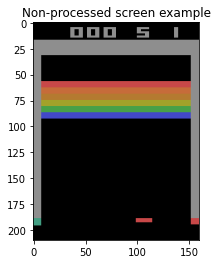

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = EnvManager(env, device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()

#### Processed Screen

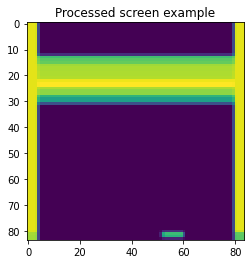

In [38]:
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show()

#### Starting State

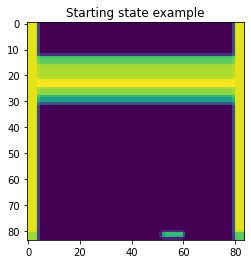

In [39]:
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Starting state example')
plt.show()

#### Non-Starting State

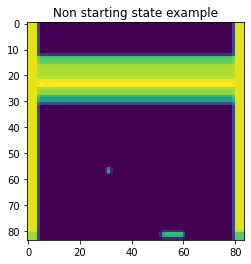

In [40]:
for i in range(5):
    em.take_action(torch.tensor([1]))
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Non starting state example')
plt.show()

#### Ending State

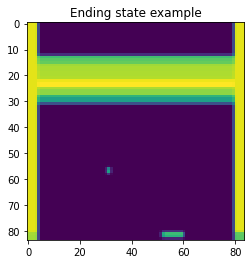

In [41]:
em.done = True
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Ending state example')
plt.show()
em.close()

## Utility Functions

### Plotting

In [42]:
def plot_durations(values, moving_avg_period):
    plt.figure(1, figsize=(10,7))
    plt.clf()  # Clear the current figure.
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Duration', fontsize=14)
    plt.plot(values)
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
        moving_avg_period, "episode duration moving avg:", moving_avg[-1])
    #if is_ipython: display.clear_output(wait=True)

def plot_rewards(values, moving_avg_period):
    plt.figure(2, figsize=(10,7))
    plt.clf()
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Reward', fontsize=14)
    plt.plot(values)
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
        moving_avg_period, "episode reward moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
    else:
        moving_avg = torch.zeros(len(values))
    return moving_avg.numpy()

def plot_loss(values):
    plt.figure(3, figsize=(10,7))
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.plot(values)
    plt.pause(0.001)
    if is_ipython: display.clear_output(wait=True)

### Tensor Processing

In [43]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

**Exapmple of `Experience(*zip(*experiences))` used above.**

See https://stackoverflow.com/a/19343/3343043 for further explanation.

In [44]:
e1 = Experience(1,1,1,1)
e2 = Experience(2,2,2,2)
e3 = Experience(3,3,3,3)

experiences = [e1,e2,e3]
experiences

[Experience(state=1, action=1, next_state=1, reward=1),
 Experience(state=2, action=2, next_state=2, reward=2),
 Experience(state=3, action=3, next_state=3, reward=3)]

In [45]:
batch = Experience(*zip(*experiences))
batch

Experience(state=(1, 2, 3), action=(1, 2, 3), next_state=(1, 2, 3), reward=(1, 2, 3))

## Q-Value Calculator

In [46]:
class QValues():

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

    @staticmethod        
    def get_next(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

## Main Program

In [47]:
# Hyperparameters
batch_size = 32
gamma = 0.99
eps_start = 1
eps_end = 0.1
eps_decay = 0.000001
target_update = 100
memory_size = 100000
lr = 0.00025
num_episodes = 12000

In [48]:
# Essential Objects

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

em = EnvManager(env, device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width(), em.num_actions_available()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width(), em.num_actions_available()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()  # since we only use this net for inference

optimizer = optim.RMSprop(params = policy_net.parameters(), lr = lr)

Training on device: cpu


In [51]:
x = em.get_processed_screen()
x = torch.cat((x, x, x, x), 1)
policy_net(x)

tensor([[-3.0720e-02, -2.3417e-02, -8.1044e-03,  6.5405e-05]],
       grad_fn=<AddmmBackward>)

In [ ]:
target_update = 1
num_episodes = 5

### Training Loop

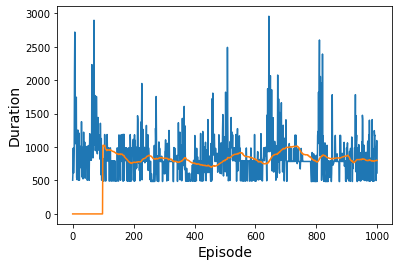

Episode 1000 
 100 episode duration moving avg: 799.7


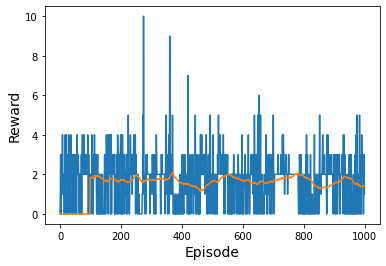

Episode 1000 
 100 episode reward moving avg: 1.4


In [24]:
episode_durations = []
episode_rewards = []
losses = []

policy_net.train()

for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    episode_reward = 0

    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        episode_reward += reward
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state

        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)

            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = rewards + (gamma * next_q_values)  # Bellman's equation

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            losses.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if em.done:
            #episode_durations.append(timestep)
            #plot_durations(episode_durations, 100)
            episode_rewards.append(episode_reward)
            plot_rewards(episode_rewards, 100)
            break

    if episode % target_update == 0:
        exchange_weights(target_net, policy_net)
        save_checkpoint(episode, policy_net, optimizer, num_episodes)

save_weights(policy_net, "CNN_" + version)
em.close()

In [ ]:
plot_loss(losses)

Let's play an episode to see if it learned to play:

In [25]:
#policy_net = DQN(em.get_screen_height(), em.get_screen_width(), em.num_actions_available()).to(device)
#load_weights(policy_net, "CNN_" + version + ".pt")
policy_net.eval()

for episode in range(1):
    em.reset()
    state = em.get_state()
    
    for timestep in count():
        em.render()
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        state = em.get_state()
        if em.done:
            break
        
em.close()

In [27]:
# restore checkpoint
# filename = os.path.join(folder_save, "checkpoint.pt")
# checkpoint = torch.load(filename)
# policy_net = DQN(em.get_screen_height(), em.get_screen_width(), em.num_actions_available()).to(device)
# policy_net.load_state_dict(checkpoint["parameters"])
# optimizer.load_state_dict(checkpoint["optimizer"])
# episode_restart = checkpoint["episode"]
# for epoch in range(episode_restart, num_episodes):
#     # train loop

Let's observe the episode durations:

In [26]:
print(f"First 100 episodes average: {get_moving_average(100, episode_durations[:100])[99]}")
print(f"Last 100 episodes average: {get_moving_average(100, episode_durations[900:])[99]}")
print(f"Middle 100 episodes average: {get_moving_average(100, episode_durations[650:750])[99]}")

First 100 episodes average: 1023.4299926757812
Last 100 episodes average: 799.7000122070312
Middle 100 episodes average: 927.8400268554688


In [27]:
print(np.max(episode_durations))
print(np.argmax(episode_durations))
print(episode_rewards[np.argmax(episode_durations)].item())

2955
644
2.0
